<a href="https://colab.research.google.com/github/khalil-alexander/get_forecast/blob/main/Newrecent_DataAnalytics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="red"> Pip install Astropy in google colab <font/>
### <font color="Green"> We install astropy in order to convert kilometre to longitatide later <font/>

In [1]:
!pip install astropy
!pip install country_converter
!pip install shapely
!pip install cartopy
!pip install geopandas
!pip install movingpandas
!pip install hvplot
!pip install holoviews
!pip install geoviews
!pip install global_land_mask
!pip install reverse_geocode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.7 MB/s eta 0:00:00


## <font color="red"> Install Moudles in google colab <font/>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from astropy import coordinates as coord
from astropy import units as u
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle

In [4]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as reqs
import xml.etree.ElementTree as ET
import io
import pprint
import json
import datetime

In [5]:
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from geopy.geocoders import Nominatim

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as mcm

In [7]:
import cartopy
import cartopy.crs as ccrs
import country_converter as coco
from cartopy.feature.nightshade import Nightshade
from global_land_mask import globe

In [8]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [9]:
import holoviews as hv
import hvplot.pandas
import geoviews

In [10]:
import os
from pathlib import Path
import datetime as dt
from datetime import timezone

In [11]:
from datetime import datetime
import datetime as dt
from datetime import timezone

In [12]:
import xarray as xr

In [13]:
from global_land_mask import globe
import reverse_geocode

In [14]:
import seaborn as sns

In [15]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [16]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




## <font color="red"> read_xml_DateFrame <font/>
### <font color="green">A function that reads an xml file and returns the specfic position the ISS is at during different time. <font/>

<font color="blue"> We pass in the url of an XML file:https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml
<font color="blue"> We use the XML file to webscrap data on the the position of the ISS and time the ISS was in that posistion.

<font color="blue"> In order to clean up the data we use Beautifulsoup

### <font color="green">What is Beautifulsoup? <font/>

<font color="blue">Beautifulsoup is a python libary that is used to pull XML and HTML files. In this case we want to pull out an XML file. <font/>

<font color="blue">The XML file we used to extract data from: https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml <font/>

In [17]:
def read_xml_DataFrame(url):
    """
    Do web scraping from an XML file to obtain time the International Space
    Station will be at a specfic postion and the speed it is going at.

    Parameters
    ----------
    url : String
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station is at
        a specfic position and the speed it is traveling.
    """
    # Get the xml request
    xml = reqs.get(url)

    # Use BeautifulSoup to Organize the XML file
    soup = BeautifulSoup(xml.content,"lxml")

    # Finds all the instances 'statevector' appeared in the xml file
    state_tag = soup.find_all('statevector')

    col_name = ['Date','x units(km)',
                'y units(km)','z units(km)',
                'x_dot(km/s)',
                'y_dot(km/s)','z_dot(km/s)']
    df = pd.DataFrame(columns=col_name)

    #Loops thorugh all elements to add rows in the empty xml_df
    for element in state_tag:
        # Turns element into text and splits the '\n'
        element = element.text.split('\n')
        # Deletes First empty String
        element.pop(0)
        # Deletes Last empty Sting
        element.pop(-1)
        # Removes the 'Z' in the elements first index
        element[0] = element[0][:-1]

        # Appending list into DataFrame by adding 1 row to the DataFrame
        #df = xml_df.append(pd.DataFrame(element, columns=col_name), ignore_index=True)
        df.loc[len(df)] = element


    # Turns the "Date" collumn into a Datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%jT%H:%M:%S.%f')
    # Sets the "Date" collumn into a Datetime object
    #df.set_index("Date", inplace=True)

    # Returns the Dataframe
    return df

In [18]:
xml_url = "https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml"
%time df = read_xml_DataFrame(xml_url)

CPU times: user 9.26 s, sys: 150 ms, total: 9.41 s
Wall time: 9.85 s


In [19]:
df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)
0,2025-04-09 12:00:00.000,-4500.7163604510397,1293.5194016553901,-4935.4531695224496,0.36126482034209001,-7.3035156793963099,-2.2412050916100199
1,2025-04-09 12:04:00.000,-4252.4017268820298,-484.90727812321501,-5287.94784611666,1.6953999384458001,-7.4267821348760403,-0.67845274055743998
2,2025-04-09 12:08:00.000,-3696.7475537298801,-2228.2868494873001,-5257.1591578258503,2.9070416386411799,-7.0132031677431099,0.93357466736134997
3,2025-04-09 12:12:00.000,-2873.8078705632001,-3810.5353101007199,-4845.1627811354801,3.9093348945734299,-6.0919607010075403,2.47910698903299
4,2025-04-09 12:16:00.000,-1842.8645373797799,-5116.9364153994002,-4081.4595439466002,4.6298141465602702,-4.7281496731959596,3.8466435526293101
...,...,...,...,...,...,...,...
5721,2025-04-24 11:46:46.511,-1571.4257270252001,-5034.6369031986897,4277.0375324993001,6.7202679298407997,0.93931431609292004,3.5639188214211401
5722,2025-04-24 11:50:46.511,79.004428720354198,-4628.7616833663296,4965.89365052422,6.9492959300688897,2.4222228180860701,2.14147495534489
5723,2025-04-24 11:54:46.511,1723.6915045206799,-3886.1409097697301,5292.45390011571,6.6727486754006504,3.72843396580866,0.56326275250216995
5724,2025-04-24 11:58:46.511,3243.00955218024,-2860.8746126139599,5232.98387704778,5.9109423582857801,4.7632961250727597,-1.0558101990028601


In [20]:
df[['lat','lon']] = df.apply(get_latlon, axis=1, result_type='expand')

In [21]:
df = df[['Date','lat','lon']]

In [22]:
df

,Date,lat,lon
0,2025-04-09 12:00:00.000,-46.818347,146.259479
1,2025-04-09 12:04:00.000,-51.329839,167.857344
2,2025-04-09 12:08:00.000,-50.910354,-168.501077
3,2025-04-09 12:12:00.000,-45.698101,-147.580214
4,2025-04-09 12:16:00.000,-37.109540,-131.380763
...,...,...,...
5721,2025-04-24 11:46:46.511,39.172316,-136.571695
5722,2025-04-24 11:50:46.511,47.188130,-119.305008
5723,2025-04-24 11:54:46.511,51.457025,-97.376575
5724,2025-04-24 11:58:46.511,50.710603,-73.670042


In [23]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [24]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




In [25]:
# Writing a function to return if there is land in a given latitude/longitude
# Function returns 1 if there is land and returns 0 if there is ocean.
def get_land_flag(row):
    """
    Extract the land_flag given the latitude/longitude information.
    This function provides if there is land in a given latitude/longitude. If
    not then we can assume the given latitude/longitude is on the ocean.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    land_flag : boolen
       If land_flag is true or not
    """
    # Gets checks if there is land in the given latitude/longitude
    land_flag = globe.is_land(row['lat'],row['lon'])
    # Returns land flag
    return land_flag

In [26]:
# Getting the name of a country with latitude/longitude
# Returns the name of the country
def get_country_name(lat: float, lon: float) -> str:
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Turn latitude and longitude into a tuple
    lat_lon = (lat, lon),
    # Get location with geocode
    loc_name = reverse_geocode.search(lat_lon)
    # Returns Country name
    return loc_name[0].get('country', '')

In [27]:
# Using the function get_county_name we obtain the country if land_flag is true
# Returns name of country if land_flag is true, otherwise returns 'Ocean'
def obtain_country_name(row):
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    row: Pandas Dataframe
       Dataframe expected to contain the latitude and longitude

       lat : float
         Latitude of the location
       lon : float
         Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Checks if land_flag is true
    if row['land_flag'] == 1:
        # Gets latitude and longitude
        lat = row['lat']
        lon = row['lon']
        # Gets country name
        country = get_country_name(lat, lon)
        # Retuns country name
        return country
    else:
        # Returns ocean if land_flag is false
        return "Ocean"

In [28]:
def get_overpassed_countries(df: pd.DataFrame, country_dict: dict):
    """
    Counts the amount of countrys the ISS flys over.

    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    count : Int
        The number of countrys the ISS flys over.
    """
    list_countries = df["Country"].unique().tolist()
    list_countries.remove("Ocean")

    for country in list_countries:
        if country in country_dict:
            country_dict[country] += 1
        else:
            country_dict[country] = 1
    return country_dict


In [29]:
def count_countrys(df: pd.DataFrame):
    """
    Counts the amount of countrys the ISS flys over.

    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    count : Int
        The number of countrys the ISS flys over.
    """
    country_dict = {}
    previous_name = ""
    country_count = 0
    for name, land_flag in zip(df['Country'], df['land_flag']):
        if (previous_name != name) and (name not in country_dict) and land_flag == True:
            if name not in country_dict:
                country_dict[name] = 1
                country_count += 1

        previous_name = name
    print(country_dict)
    print(country_count)
    return country_count


In [30]:
def create_list_orbits(df: pd.DataFrame) -> list:
    """

    """
    list_orbits = list()
    temp_df = df['lon']
    first_index = 0
    second_index = 0


    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            second_index = i+1
            list_orbits.append(df[first_index:second_index])
            first_index = second_index

    list_orbits.append(df[second_index:])


    return list_orbits

In [31]:
def get_interpolated_data(df: pd.DataFrame, seconds='20s') -> pd.DataFrame:
    """

    """

    df.rename(columns={'Date': 't'}, inplace=True)

    df.set_index('t', inplace=True)
    ds = df.to_xarray()

    start_date = df.index[0] + dt.timedelta(seconds=5)
    start_date = datetime.fromtimestamp(start_date.timestamp())
    start_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')

    end_date = df.index[-1] - dt.timedelta(seconds=5)
    end_date = datetime.fromtimestamp(end_date.timestamp())
    end_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')

    new_dates = pd.date_range(start_date, end_date, freq=seconds)
    interpolated_data = ds.interp(t=new_dates, method='linear')
    interpolated_df = interpolated_data.to_dataframe()

    return interpolated_df

In [32]:
def get_interpolated_data2(df: pd.DataFrame, seconds='20s') -> pd.DataFrame:
    ds = df.to_xarray()

    start_date = df.index[0] + dt.timedelta(seconds=5)
    start_date = datetime.fromtimestamp(start_date.timestamp())
    start_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')

    end_date = df.index[-1] - dt.timedelta(seconds=5)
    end_date = datetime.fromtimestamp(end_date.timestamp())
    end_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')

    new_dates = pd.date_range(start_date, end_date, freq=seconds)
    interpolated_data = ds.interp(t=new_dates, method='linear')
    interpolated_df = interpolated_data.to_dataframe()

    return interpolated_df


In [33]:
def interpolate_orbits(df_list: list, seconds='20s') -> list:
    count = 0
    new_df_list = list()
    for element in df_list:
        element = get_interpolated_data(element, seconds)
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
        new_df_list.append(element)


    return new_df_list



In [34]:
def interpolate_orbits2(df_list: list, seconds='20s') -> list:
    count = 0
    new_df_list = list()
    for element in df_list:
        element = get_interpolated_data2(element, seconds)
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
        new_df_list.append(element)


    return new_df_list



In [35]:
def get_all_countrys(df_list: list) -> dict:
    """

    """
    country_dict = dict()
    for df in df_list:
        country_dict = get_overpassed_countries(df, country_dict)
    return country_dict

In [36]:
orbit_list = create_list_orbits(df)

In [37]:
orbit_list

[                 Date        lat         lon
 0 2025-04-09 12:00:00 -46.818347  146.259479
 1 2025-04-09 12:04:00 -51.329839  167.857344,
                   Date        lat         lon
 2  2025-04-09 12:08:00 -50.910354 -168.501077
 3  2025-04-09 12:12:00 -45.698101 -147.580214
 4  2025-04-09 12:16:00 -37.109540 -131.380763
 5  2025-04-09 12:20:00 -26.545375 -119.001559
 6  2025-04-09 12:24:00 -14.918855 -108.966854
 7  2025-04-09 12:28:00  -2.795052 -100.078819
 8  2025-04-09 12:32:00   9.420565  -91.387677
 9  2025-04-09 12:36:00  21.347570  -81.989906
 10 2025-04-09 12:40:00  32.508174  -70.814923
 11 2025-04-09 12:44:00  42.162892  -56.472243
 12 2025-04-09 12:48:00  49.110253  -37.573538
 13 2025-04-09 12:52:00  51.787834  -14.529366
 14 2025-04-09 12:56:00  49.331491    8.623083
 15 2025-04-09 13:00:00  42.546363   27.727195
 16 2025-04-09 13:04:00  32.995488   42.234778
 17 2025-04-09 13:08:00  21.901996   53.507164
 18 2025-04-09 13:12:00  10.019498   62.946762
 19 2025-04-09 

In [38]:
def comp_interpolated_orbits(orbit_list: list, seconds='20s') -> list:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    interpolated_list : list
        A list of orbits with the interpolated data.
        A dictionary of countrys the ISS flys over.
    """

    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits(orbit_list, seconds=seconds)
    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
    return interpolated_list

In [39]:
interpolated_list = comp_interpolated_orbits(orbit_list, seconds='20s')
country_list = get_all_countrys(interpolated_list)

In [40]:
len(country_list)

166

In [41]:
def get_all(df: pd.DataFrame, seconds='20s') -> dict:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    country_dict : dict
        A dictionary of countrys the ISS flys over.
    """
    # Make a deep copy of the dataframe
    mydf = df.copy()
    # Create a list of orbits with the copy of the dataframe
    orbit_list = create_list_orbits(mydf)

    # Only consider orbits with at least two points
    orbit_list = [item for item in orbit_list if len(item) > 1]


    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits(orbit_list, seconds=seconds)

    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')

    country_dict = get_all_countrys(interpolated_list)
    return country_dict


In [42]:
def get_all2(df: pd.DataFrame, seconds='20s') -> dict:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    country_dict : dict
        A dictionary of countrys the ISS flys over.
    """
    # Make a deep copy of the dataframe
    mydf = df.copy()
    # Create a list of orbits with the copy of the dataframe
    orbit_list = create_list_orbits(mydf)

    # Only consider orbits with at least two points
    orbit_list = [item for item in orbit_list if len(item) > 1]


    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits2(orbit_list, seconds=seconds)

    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')

    country_dict = get_all_countrys(interpolated_list)
    return country_dict


### <font color="green"> Interpolation Tests

In [43]:
%time test_list_15 = get_all(df, seconds='15s')

CPU times: user 36.5 s, sys: 150 ms, total: 36.6 s
Wall time: 37 s


In [44]:
%time test_list_20 = get_all(df, seconds='20s')

CPU times: user 27.5 s, sys: 115 ms, total: 27.6 s
Wall time: 27.8 s


In [45]:
%time test_list_25 = get_all(df, seconds='25s')

CPU times: user 23.6 s, sys: 85.7 ms, total: 23.6 s
Wall time: 23.8 s


In [46]:
%time test_list_30 = get_all(df, seconds='30s')

CPU times: user 19.9 s, sys: 86.5 ms, total: 20 s
Wall time: 20.1 s


In [47]:
%time test_list_10 = get_all(df, seconds='10s')

CPU times: user 52.5 s, sys: 220 ms, total: 52.7 s
Wall time: 53.1 s


In [48]:
%time test_list_5 = get_all(df, seconds='5s')

CPU times: user 1min 43s, sys: 496 ms, total: 1min 43s
Wall time: 1min 44s


In [49]:
keys15 = set(test_list_15.keys())
keys20 = set(test_list_20.keys())
keys25 = set(test_list_25.keys())
keys30 = set(test_list_30.keys())
keys10 = set(test_list_10.keys())
keys5 = set(test_list_5.keys())

In [50]:
print(len(keys5))
print(len(keys10))
print(len(keys15))
print(len(keys20))
print(len(keys25))
print(len(keys30))

177
174
165
166
162
161


In [51]:
keys30-keys5

set()

Create a table
First column: Freq
Second column: How long it takes to run: Computing time
Third Column: How many countries does the ISS pass: Number of Countries and

### <font color="blue"> Data was gathered on Feburary 26th 12:18pm EST from a function that interpolates data then returns a dictionary of the countrys
| Frequency in seconds(s) | Computing time in seconds (s) | Number of countries and territories ISS pass |
|-------------------------|-------------------------------|--------------------
| 5                       |             104               |        180
| 10                      |              60               |        179
| 15                      |             37.7              |        169
| 20                      |             28.5              |        165
| 25                      |             23.3              |        164
| 30                      |             20.1              |        164

In [52]:
keys20-keys15

{'Brunei Darussalam', 'Guernsey', 'Niue', 'Saint Pierre and Miquelon', 'Samoa'}

In [53]:
keys15-keys10

{'Vanuatu'}

In [54]:
keys10-keys15

{'Brunei Darussalam',
 'Comoros',
 'Fiji',
 'Guernsey',
 'Lesotho',
 'Niue',
 'Saint Pierre and Miquelon',
 'Samoa',
 'Sao Tome and Principe',
 'Swaziland'}

In [55]:
keys10-keys20

{'Comoros',
 'Fiji',
 'Guadeloupe',
 'Lesotho',
 'Montenegro',
 'Sao Tome and Principe',
 'Swaziland',
 'Tonga'}

In [56]:
keys30-keys10

set()

In [57]:
df

,Date,lat,lon
0,2025-04-09 12:00:00.000,-46.818347,146.259479
1,2025-04-09 12:04:00.000,-51.329839,167.857344
2,2025-04-09 12:08:00.000,-50.910354,-168.501077
3,2025-04-09 12:12:00.000,-45.698101,-147.580214
4,2025-04-09 12:16:00.000,-37.109540,-131.380763
...,...,...,...
5721,2025-04-24 11:46:46.511,39.172316,-136.571695
5722,2025-04-24 11:50:46.511,47.188130,-119.305008
5723,2025-04-24 11:54:46.511,51.457025,-97.376575
5724,2025-04-24 11:58:46.511,50.710603,-73.670042


### <font color="green"> Range of Specific date

In [58]:
def get_range(df: pd.DataFrame ,start_date: str, end_date: str):
    """
    Reads DataFrame, then takes the range between the start and end date.
    ----------
    df : Pandas DataFrame

    Return
    ------
    df : Pandas DataFrame
        A specific range of the df from a start date to an end date.
    """

    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    for element in df["Date"]:
        if element >= start_date:
            start_date = element
            break
    for element in df["Date"]:
        if element >= end_date:
            end_date = element
            break
    print(start_date)
    print(end_date)
    print(type(start_date))
    print(type(end_date))

    #start_num = df.loc[(df['Date'] >= start_date)]
    #print(start_num)
    #end_num = df.loc[(df['Date'] <= end_date)]
    #print(end_num)
    return df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)



In [59]:
start_date = dt.datetime.now()

In [60]:
start_date

datetime.datetime(2025, 4, 10, 16, 19, 17, 21178)

In [61]:
end_date = dt.datetime.now() + dt.timedelta(days=1)

In [62]:
start_date = start_date.strftime("%Y-%m-%d %H:%M:%S")

In [63]:
end_date = end_date.strftime("%Y-%m-%d %H:%M:%S")

In [64]:
day_df = get_range(df, start_date, end_date)

2025-04-10 16:20:00
2025-04-11 16:20:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


test with how many countries fly over the new get_range function (use 5s freqency)

In [65]:
df

,Date,lat,lon
0,2025-04-09 12:00:00.000,-46.818347,146.259479
1,2025-04-09 12:04:00.000,-51.329839,167.857344
2,2025-04-09 12:08:00.000,-50.910354,-168.501077
3,2025-04-09 12:12:00.000,-45.698101,-147.580214
4,2025-04-09 12:16:00.000,-37.109540,-131.380763
...,...,...,...
5721,2025-04-24 11:46:46.511,39.172316,-136.571695
5722,2025-04-24 11:50:46.511,47.188130,-119.305008
5723,2025-04-24 11:54:46.511,51.457025,-97.376575
5724,2025-04-24 11:58:46.511,50.710603,-73.670042


In [66]:
day_df

,Date,lat,lon
0,2025-04-10 16:20:00,-2.149155,-164.461812
1,2025-04-10 16:24:00,10.061386,-155.757492
2,2025-04-10 16:28:00,21.962066,-146.295805
3,2025-04-10 16:32:00,33.065990,-134.991527
4,2025-04-10 16:36:00,42.613852,-120.437552
...,...,...,...
356,2025-04-11 16:04:00,44.390851,-35.045759
357,2025-04-11 16:08:00,35.339694,-19.583742
358,2025-04-11 16:12:00,24.513900,-7.708198
359,2025-04-11 16:16:00,12.758908,2.043958


In [67]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    361 non-null    datetime64[ns]
 1   lat     361 non-null    float64       
 2   lon     361 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.6 KB


In [68]:
day_df.isnull().sum()

,0
Date,0
lat,0
lon,0


In [69]:
day_dict = get_all(day_df, seconds='5s')

In [70]:
day_dict

{'United States': 8,
 'Canada': 7,
 'Western Sahara': 1,
 'Morocco': 2,
 'Mauritania': 1,
 'Mali': 3,
 'Burkina Faso': 2,
 'Ghana': 1,
 'Angola': 2,
 'Namibia': 2,
 'Botswana': 1,
 'South Africa': 2,
 'Lesotho': 1,
 'French Southern Territories': 1,
 'Australia': 4,
 'Papua New Guinea': 1,
 'Brazil': 4,
 'Indonesia': 4,
 'Cuba': 1,
 'Colombia': 1,
 'Venezuela': 1,
 'Malaysia': 2,
 'Taiwan': 1,
 'Japan': 2,
 'Mexico': 3,
 'Chile': 6,
 'Argentina': 6,
 'Myanmar': 1,
 'China': 7,
 'Russian Federation': 7,
 'India': 2,
 'Mongolia': 4,
 'Zambia': 1,
 'Congo, The Democratic Republic of the': 1,
 'Burundi': 1,
 'Rwanda': 1,
 'Tanzania, United Republic of': 2,
 'Uganda': 2,
 'Kenya': 2,
 'Ethiopia': 1,
 'Eritrea': 1,
 'Yemen': 2,
 'Saudi Arabia': 2,
 'Qatar': 1,
 'Iran, Islamic Republic of': 3,
 'Afghanistan': 2,
 'Turkmenistan': 1,
 'Uzbekistan': 3,
 'Tajikistan': 2,
 'Kyrgyzstan': 1,
 'Kazakhstan': 5,
 'Equatorial Guinea': 2,
 'Cameroon': 1,
 'Chad': 2,
 'Libyan Arab Jamahiriya': 3,
 'Egypt'

In [71]:
#orbit_list = create_list_orbits(day_df)

In [72]:
#%time daily_dict = comp_interpolated_orbits(orbit_list, seconds='5s')

In [73]:
len(day_dict)

107

### <font color="green"> When have country list, create a bar plot where the list of countries, reorder by decreasing order of the number of times the ISS passes over the country.

In [74]:
day_items = sorted(day_dict.items(), key=lambda x: x[1], reverse=True)
day_items

[('United States', 8),
 ('Canada', 7),
 ('China', 7),
 ('Russian Federation', 7),
 ('Chile', 6),
 ('Argentina', 6),
 ('Kazakhstan', 5),
 ('Australia', 4),
 ('Brazil', 4),
 ('Indonesia', 4),
 ('Mongolia', 4),
 ('Ukraine', 4),
 ('Mali', 3),
 ('Mexico', 3),
 ('Iran, Islamic Republic of', 3),
 ('Uzbekistan', 3),
 ('Libyan Arab Jamahiriya', 3),
 ('Algeria', 3),
 ('France', 3),
 ('Morocco', 2),
 ('Burkina Faso', 2),
 ('Angola', 2),
 ('Namibia', 2),
 ('South Africa', 2),
 ('Malaysia', 2),
 ('Japan', 2),
 ('India', 2),
 ('Tanzania, United Republic of', 2),
 ('Uganda', 2),
 ('Kenya', 2),
 ('Yemen', 2),
 ('Saudi Arabia', 2),
 ('Afghanistan', 2),
 ('Tajikistan', 2),
 ('Equatorial Guinea', 2),
 ('Chad', 2),
 ('Egypt', 2),
 ('Israel', 2),
 ('Turkey', 2),
 ('Azerbaijan', 2),
 ('Armenia', 2),
 ('Greece', 2),
 ('Spain', 2),
 ('Italy', 2),
 ('Hungary', 2),
 ('Slovakia', 2),
 ('Belgium', 2),
 ('Germany', 2),
 ('Pakistan', 2),
 ('Western Sahara', 1),
 ('Mauritania', 1),
 ('Ghana', 1),
 ('Botswana', 1),
 

In [75]:
day_df = pd.DataFrame(day_items, columns=['Countries', 'Count'])

In [76]:
day_df[25:50]

,Countries,Count
25,Japan,2
26,India,2
27,"Tanzania, United Republic of",2
28,Uganda,2
29,Kenya,2
30,Yemen,2
31,Saudi Arabia,2
32,Afghanistan,2
33,Tajikistan,2
34,Equatorial Guinea,2


In [77]:
day_df.groupby('Count').sum()

,Countries
Count,
1,Western SaharaMauritaniaGhanaBotswanaLesothoFr...
2,MoroccoBurkina FasoAngolaNamibiaSouth AfricaMa...
3,"MaliMexicoIran, Islamic Republic ofUzbekistanL..."
4,AustraliaBrazilIndonesiaMongoliaUkraine
5,Kazakhstan
6,ChileArgentina
7,CanadaChinaRussian Federation
8,United States


In [78]:
day_group = day_df.groupby('Count').apply(lambda x: x['Countries'] )

In [79]:
day_group

Count    
1      49        Western Sahara
       50            Mauritania
       51                 Ghana
       52              Botswana
       53               Lesotho
                    ...        
6      5              Argentina
7      1                 Canada
       2                  China
       3     Russian Federation
8      0          United States
Name: Countries, Length: 107, dtype: object

In [80]:
for element in day_group:
    print(element)
    break

Western Sahara


In [81]:
n = 10 # First n number of countries
new_day_df = day_df[0:n]

In [82]:
new_day_df

,Countries,Count
0,United States,8
1,Canada,7
2,China,7
3,Russian Federation,7
4,Chile,6
5,Argentina,6
6,Kazakhstan,5
7,Australia,4
8,Brazil,4
9,Indonesia,4


In [83]:
new_df = pd.DataFrame(columns=['Countries', 'Count'])

In [84]:
new_df

,Countries,Count


Pandas: groupby,


In [85]:
for element in day_df:
    print(element)
    break
    if element.count > 1:
        new_df.append(element)

Countries


In [86]:
day_df

,Countries,Count
0,United States,8
1,Canada,7
2,China,7
3,Russian Federation,7
4,Chile,6
...,...,...
102,Comoros,1
103,Madagascar,1
104,Niger,1
105,Benin,1


In [87]:
day_dict = dict(day_items)

In [88]:
new_dict = dict()

In [89]:
for key, value in day_dict.items():
    if value >= 5:
        new_dict[key] = value

In [90]:
new_dict

{'United States': 8,
 'Canada': 7,
 'China': 7,
 'Russian Federation': 7,
 'Chile': 6,
 'Argentina': 6,
 'Kazakhstan': 5}

### <font color="green"> Plots of the Overpassed Countries

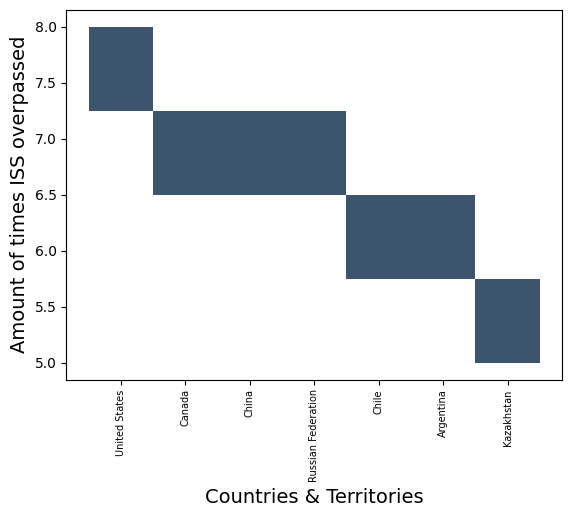

In [91]:
ax = sns.histplot(data=day_dict, x=new_dict.keys(), y=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
plt.show()

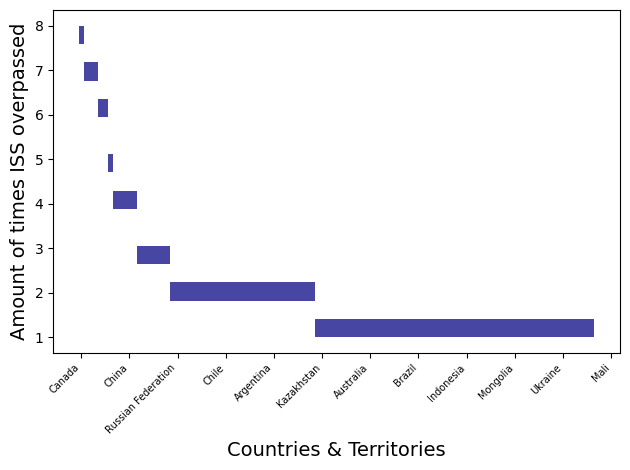

<Figure size 2000x1000 with 0 Axes>

In [92]:
ax = sns.histplot(data=day_dict, x=day_dict.keys(), y=day_dict.values(), color='blue', fill=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontdict={'fontsize': 7}, ha='right')
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.tight_layout()
plt.figure(figsize=(20,10))
plt.show()

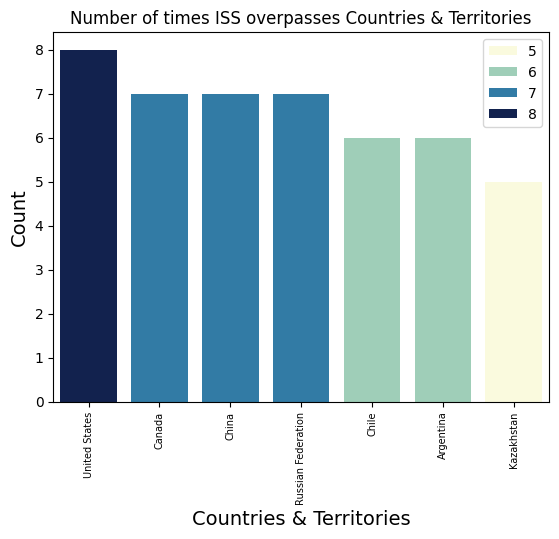

In [93]:
ax = sns.barplot(data=new_dict, x=new_dict.keys(), y=new_dict.values(), palette="YlGnBu", hue=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title("Number of times ISS overpasses Countries & Territories")
plt.show()

In [94]:
day_df.groupby('Count').sum()

,Countries
Count,
1,Western SaharaMauritaniaGhanaBotswanaLesothoFr...
2,MoroccoBurkina FasoAngolaNamibiaSouth AfricaMa...
3,"MaliMexicoIran, Islamic Republic ofUzbekistanL..."
4,AustraliaBrazilIndonesiaMongoliaUkraine
5,Kazakhstan
6,ChileArgentina
7,CanadaChinaRussian Federation
8,United States


In [95]:
day_df

,Countries,Count
0,United States,8
1,Canada,7
2,China,7
3,Russian Federation,7
4,Chile,6
...,...,...
102,Comoros,1
103,Madagascar,1
104,Niger,1
105,Benin,1


In [96]:
day_group = day_df.groupby('Count').apply(lambda x: x['Countries'] )

In [97]:
day_group

Count    
1      49        Western Sahara
       50            Mauritania
       51                 Ghana
       52              Botswana
       53               Lesotho
                    ...        
6      5              Argentina
7      1                 Canada
       2                  China
       3     Russian Federation
8      0          United States
Name: Countries, Length: 107, dtype: object

In [98]:
day_group[4]

,Countries
7,Australia
8,Brazil
9,Indonesia
10,Mongolia
11,Ukraine


In [99]:
countone = list()

In [100]:
for element in day_group[1]:
    countone.append(element)


In [101]:
countone

['Western Sahara',
 'Mauritania',
 'Ghana',
 'Botswana',
 'Lesotho',
 'French Southern Territories',
 'Papua New Guinea',
 'Cuba',
 'Colombia',
 'Venezuela',
 'Taiwan',
 'Myanmar',
 'Zambia',
 'Congo, The Democratic Republic of the',
 'Burundi',
 'Rwanda',
 'Ethiopia',
 'Eritrea',
 'Qatar',
 'Turkmenistan',
 'Kyrgyzstan',
 'Cameroon',
 'Palestinian Territory',
 'Jordan',
 'Syrian Arab Republic',
 'Liberia',
 'Guinea',
 "Cote d'Ivoire",
 'Bulgaria',
 'Solomon Islands',
 'Paraguay',
 'Slovenia',
 'Austria',
 'Philippines',
 'New Zealand',
 'Peru',
 'Guyana',
 'Poland',
 'Nepal',
 'Thailand',
 'Panama',
 'Haiti',
 'Dominican Republic',
 'United Kingdom',
 'Netherlands',
 'Czech Republic',
 'Romania',
 'Moldova, Republic of',
 'Albania',
 'Somalia',
 'Tunisia',
 'Sudan',
 'South Sudan',
 'Comoros',
 'Madagascar',
 'Niger',
 'Benin',
 'Nigeria']

In [102]:
def countby_country(df, count):
    """

    """
    country_list = list()
    for element in df.groupby('Count')[count]:
        country_list.append(element)

In [103]:
grouped_df = day_group.reset_index()
grouped_df

,Count,level_1,Countries
0,1,49,Western Sahara
1,1,50,Mauritania
2,1,51,Ghana
3,1,52,Botswana
4,1,53,Lesotho
...,...,...,...
102,6,5,Argentina
103,7,1,Canada
104,7,2,China
105,7,3,Russian Federation


In [104]:
len(grouped_df)

107

In [105]:
grouped_df

,Count,level_1,Countries
0,1,49,Western Sahara
1,1,50,Mauritania
2,1,51,Ghana
3,1,52,Botswana
4,1,53,Lesotho
...,...,...,...
102,6,5,Argentina
103,7,1,Canada
104,7,2,China
105,7,3,Russian Federation


In [106]:
125 % 23

10

In [107]:
23*5

115

### <font color="green"> Bar graphs and Pie charts

In [232]:
def plot_countriesbar(data: pd.DataFrame, n=25, title="Different Bar Plots",  x_value='x', y_value='y'):
    """
    This function plots the countries and territories the ISS overpasses. It
    plots n number of countries at a time using seaborn and matplotlib
    Parameters
    ----------
    data : Pandas DataFrame
        A dataframe of countries and territories the ISS overpasses alongside
        how many times it overpasses them.
    n : int
        Number of countries to plot at a time.
    """
    start = 0
    stop = n
    amount = len(data)
    count = amount/n
    while(count>0):
      ax = sns.barplot(data=data[start:stop], x=x_value, y=y_value, palette="YlGnBu")
      ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
      plt.xlabel("Countries & Territories", fontsize=14)
      plt.ylabel("Count", fontsize=14, )
      plt.title(title)
      plt.show()
      count -= 1
      start += n
      stop += n


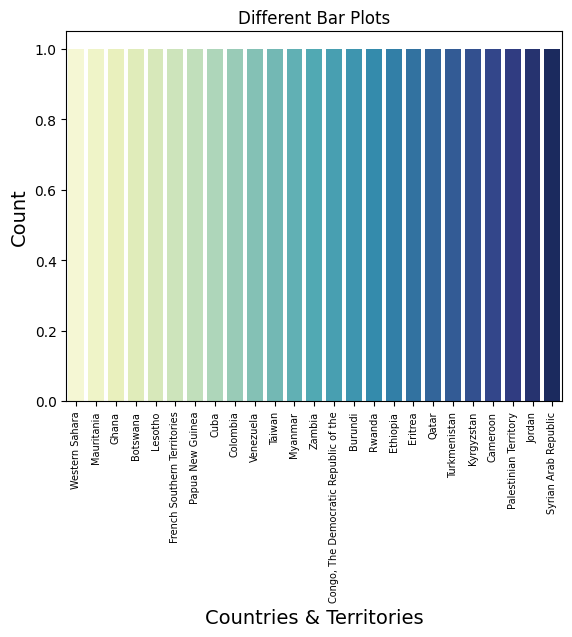

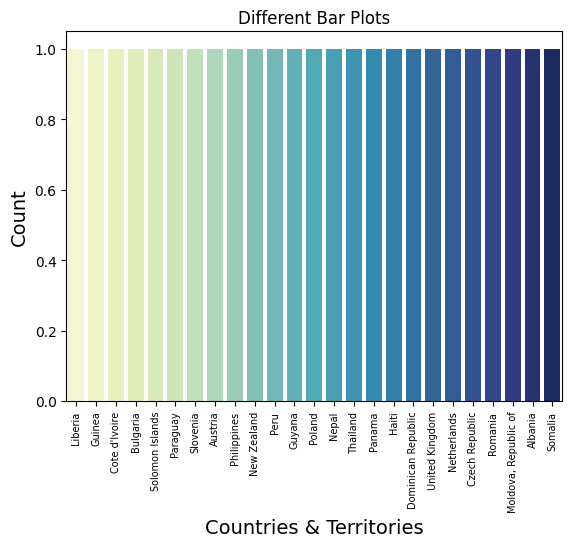

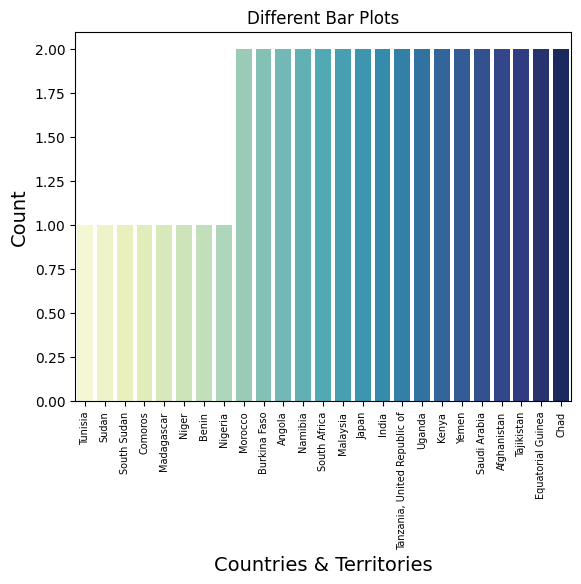

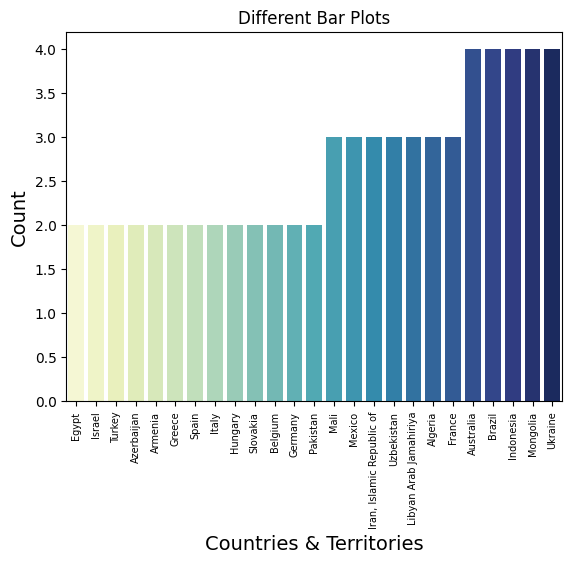

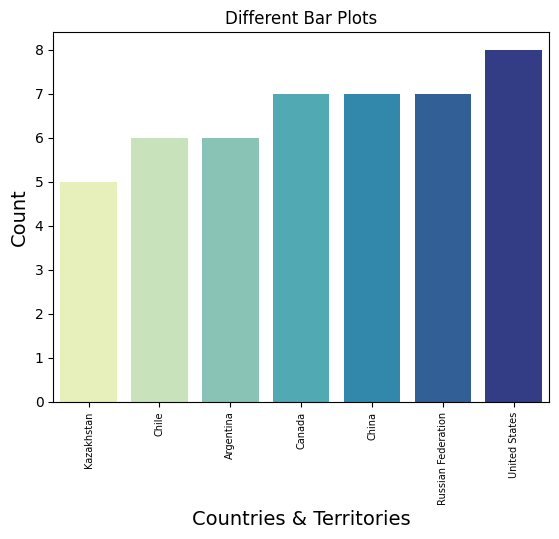

CPU times: user 1.89 s, sys: 46 ms, total: 1.94 s
Wall time: 1.95 s


In [109]:
%time plot_countriesbar(grouped_df)

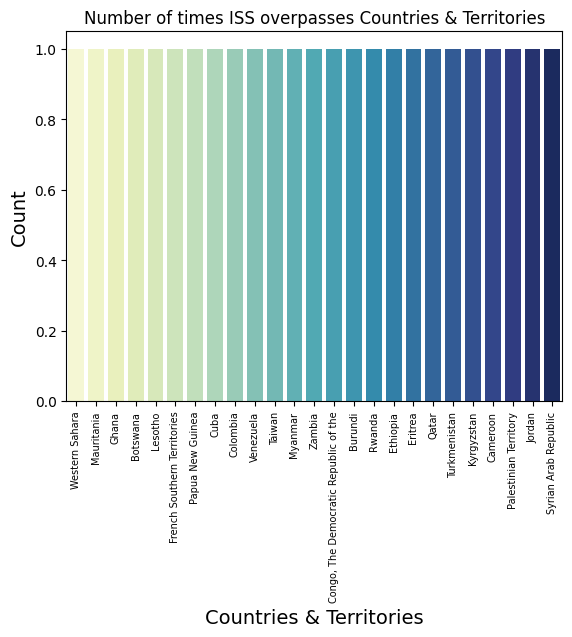

In [110]:
ax = sns.barplot(data=grouped_df[0:25], x='Countries', y='Count', palette="YlGnBu")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title("Number of times ISS overpasses Countries & Territories")
plt.show()

In [188]:
day_df

,Countries,Count
0,United States,8
1,Canada,7
2,China,7
3,Russian Federation,7
4,Chile,6
...,...,...
102,Comoros,1
103,Madagascar,1
104,Niger,1
105,Benin,1


In [111]:
count_group = day_df.groupby('Count').count()

In [112]:
count_group

,Countries
Count,
1,58
2,30
3,7
4,5
5,1
6,2
7,3
8,1


In [113]:
count_df = count_group.reset_index()
count_df

,Count,Countries
0,1,58
1,2,30
2,3,7
3,4,5
4,5,1
5,6,2
6,7,3
7,8,1


In [114]:
len(day_df)

107

Text(0.5, 1.0, '107 Countries & Territories overpassed by the ISS')

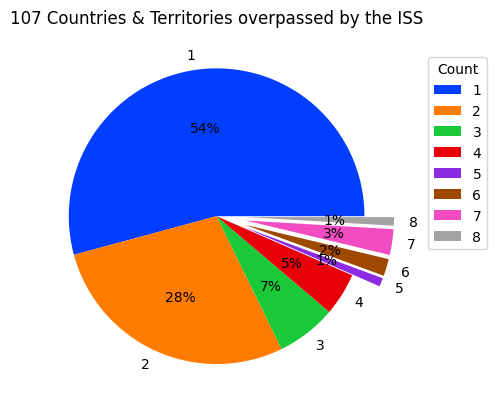

In [115]:
palette_color = sns.color_palette('bright')
explode = [0 for i in range(len(count_df))]
explode[-1] = 0.2
explode[-2] = 0.2
explode[-3] = 0.2
explode[-4] = 0.2
plt.pie(count_df['Countries'], labels=count_df['Count'], colors=palette_color, autopct='%.0f%%', explode=explode)
plt.legend(title = "Count", loc ="best", bbox_to_anchor=(0.80, -0.05, 0.45, 1))
plt.title(f"{len(day_df)} Countries & Territories overpassed by the ISS")

In [116]:
for element in day_group[1]:
    print(element)


Western Sahara
Mauritania
Ghana
Botswana
Lesotho
French Southern Territories
Papua New Guinea
Cuba
Colombia
Venezuela
Taiwan
Myanmar
Zambia
Congo, The Democratic Republic of the
Burundi
Rwanda
Ethiopia
Eritrea
Qatar
Turkmenistan
Kyrgyzstan
Cameroon
Palestinian Territory
Jordan
Syrian Arab Republic
Liberia
Guinea
Cote d'Ivoire
Bulgaria
Solomon Islands
Paraguay
Slovenia
Austria
Philippines
New Zealand
Peru
Guyana
Poland
Nepal
Thailand
Panama
Haiti
Dominican Republic
United Kingdom
Netherlands
Czech Republic
Romania
Moldova, Republic of
Albania
Somalia
Tunisia
Sudan
South Sudan
Comoros
Madagascar
Niger
Benin
Nigeria


In [117]:
day_dict.items()

dict_items([('United States', 8), ('Canada', 7), ('China', 7), ('Russian Federation', 7), ('Chile', 6), ('Argentina', 6), ('Kazakhstan', 5), ('Australia', 4), ('Brazil', 4), ('Indonesia', 4), ('Mongolia', 4), ('Ukraine', 4), ('Mali', 3), ('Mexico', 3), ('Iran, Islamic Republic of', 3), ('Uzbekistan', 3), ('Libyan Arab Jamahiriya', 3), ('Algeria', 3), ('France', 3), ('Morocco', 2), ('Burkina Faso', 2), ('Angola', 2), ('Namibia', 2), ('South Africa', 2), ('Malaysia', 2), ('Japan', 2), ('India', 2), ('Tanzania, United Republic of', 2), ('Uganda', 2), ('Kenya', 2), ('Yemen', 2), ('Saudi Arabia', 2), ('Afghanistan', 2), ('Tajikistan', 2), ('Equatorial Guinea', 2), ('Chad', 2), ('Egypt', 2), ('Israel', 2), ('Turkey', 2), ('Azerbaijan', 2), ('Armenia', 2), ('Greece', 2), ('Spain', 2), ('Italy', 2), ('Hungary', 2), ('Slovakia', 2), ('Belgium', 2), ('Germany', 2), ('Pakistan', 2), ('Western Sahara', 1), ('Mauritania', 1), ('Ghana', 1), ('Botswana', 1), ('Lesotho', 1), ('French Southern Territor

create new function with country name, return how many time it will fly over that country

In [118]:
for key, value in day_dict.items():
  print(f"Key:{key}, Value:{value}")

Key:United States, Value:8
Key:Canada, Value:7
Key:China, Value:7
Key:Russian Federation, Value:7
Key:Chile, Value:6
Key:Argentina, Value:6
Key:Kazakhstan, Value:5
Key:Australia, Value:4
Key:Brazil, Value:4
Key:Indonesia, Value:4
Key:Mongolia, Value:4
Key:Ukraine, Value:4
Key:Mali, Value:3
Key:Mexico, Value:3
Key:Iran, Islamic Republic of, Value:3
Key:Uzbekistan, Value:3
Key:Libyan Arab Jamahiriya, Value:3
Key:Algeria, Value:3
Key:France, Value:3
Key:Morocco, Value:2
Key:Burkina Faso, Value:2
Key:Angola, Value:2
Key:Namibia, Value:2
Key:South Africa, Value:2
Key:Malaysia, Value:2
Key:Japan, Value:2
Key:India, Value:2
Key:Tanzania, United Republic of, Value:2
Key:Uganda, Value:2
Key:Kenya, Value:2
Key:Yemen, Value:2
Key:Saudi Arabia, Value:2
Key:Afghanistan, Value:2
Key:Tajikistan, Value:2
Key:Equatorial Guinea, Value:2
Key:Chad, Value:2
Key:Egypt, Value:2
Key:Israel, Value:2
Key:Turkey, Value:2
Key:Azerbaijan, Value:2
Key:Armenia, Value:2
Key:Greece, Value:2
Key:Spain, Value:2
Key:Ital

In [119]:
def count_countryoverpass(count_dict: dict, country: str) -> int:
    """
    Counts the amount of times the ISS flies over a country.

    Parameters
    ----------
    count_dict : Dictionary

    Return
    ------
    count : Int
        The number of times the ISS passes over a country.
    """


    for key, value in count_dict.items():
        if key == country:
            return value
    print("Country not found")
    return 0

In [120]:
count_countryoverpass(day_dict, "United States")

8

given latitude and longitude return how many times the ISS will fly over it

In [121]:
day_df

,Countries,Count
0,United States,8
1,Canada,7
2,China,7
3,Russian Federation,7
4,Chile,6
...,...,...
102,Comoros,1
103,Madagascar,1
104,Niger,1
105,Benin,1


Create function with one indivudual orbit and name of country, Return nothing or date.

Create function that determine the next times the ISS will overpass a country name. Will return:
- Dates
- None

Loop over Orbits

May create function see when the ISS leave the country

In [122]:
interpolated_list[4]

,lat,lon,land_flag,Country
t,,,,
2025-04-09 17:04:05,-10.561371,-176.480768,False,Ocean
2025-04-09 17:04:25,-9.544939,-175.754130,False,Ocean
2025-04-09 17:04:45,-8.528508,-175.027493,False,Ocean
2025-04-09 17:05:05,-7.512076,-174.300855,False,Ocean
2025-04-09 17:05:25,-6.495645,-173.574218,False,Ocean
...,...,...,...,...
2025-04-09 18:42:25,6.070420,171.839103,False,Ocean
2025-04-09 18:42:45,7.087248,172.566317,False,Ocean
2025-04-09 18:43:05,8.104075,173.293532,False,Ocean


In [123]:
single_orbit_df = interpolated_list[4]

In [124]:
%time single_orbit_df['land_flag'] = single_orbit_df.apply(get_land_flag, axis=1, result_type='expand')
%time single_orbit_df['Country'] = single_orbit_df.apply(obtain_country_name, axis=1, result_type='expand')

CPU times: user 58.2 ms, sys: 6 µs, total: 58.2 ms
Wall time: 58.4 ms
CPU times: user 13.7 ms, sys: 10 µs, total: 13.8 ms
Wall time: 13.2 ms


In [125]:
def get_country_time(orbit_df: pd.DataFrame, country: str):
    """
    This function returns the time the ISS will fly over a country given the
    orbit and country name.

    Parameters
    ----------
    orbit_df : Pandas DataFrame
        A dataframe of a single orbit of the ISS path.
    country : str
        Name of country to search for.

    Return
    ------
    index : str
        A timestamp turned into a string of the time the ISS will fly over
        the country.
    """
    for index, row in orbit_df.iterrows():
        if country in row['Country']:
            return str(index)
    return None

In [126]:
get_country_time(single_orbit_df, 'United States')

'2025-04-09 17:23:25'

In [127]:
day_df2 = get_range(df, start_date, end_date)

2025-04-10 16:20:00
2025-04-11 16:20:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [128]:
%time day_df2['land_flag'] = day_df2.apply(get_land_flag, axis=1, result_type='expand')
%time day_df2['Country'] = day_df2.apply(obtain_country_name, axis=1, result_type='expand')

CPU times: user 67.4 ms, sys: 0 ns, total: 67.4 ms
Wall time: 68.1 ms
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.7 ms


In [129]:
day_df2

,Date,lat,lon,land_flag,Country
0,2025-04-10 16:20:00,-2.149155,-164.461812,False,Ocean
1,2025-04-10 16:24:00,10.061386,-155.757492,False,Ocean
2,2025-04-10 16:28:00,21.962066,-146.295805,False,Ocean
3,2025-04-10 16:32:00,33.065990,-134.991527,False,Ocean
4,2025-04-10 16:36:00,42.613852,-120.437552,True,United States
...,...,...,...,...,...
356,2025-04-11 16:04:00,44.390851,-35.045759,False,Ocean
357,2025-04-11 16:08:00,35.339694,-19.583742,False,Ocean
358,2025-04-11 16:12:00,24.513900,-7.708198,True,Algeria
359,2025-04-11 16:16:00,12.758908,2.043958,True,Niger


In [130]:
def get_country_time2(orbits_list: list, country: str):
    """
    This function returns list of all the times the ISS will fly over a country
    given the orbit and country name.

    Parameters
    ----------
    orbits_list: list
        A list of the ISS path.
    country : str
        Name of country to search for.

    Return
    ------
    ___ : list
        A list of times the ISS will fly over the country.
    """

    country_list = list()
    for df in orbits_list:
        for index, row in df.iterrows():
            if country in row['Country']:
                country_list.append(str(index))

    return country_list

In [131]:
get_country_time2(interpolated_list[4:7], 'United States')

['2025-04-09 17:23:25',
 '2025-04-09 17:23:45',
 '2025-04-09 17:24:05',
 '2025-04-09 17:24:25',
 '2025-04-09 17:24:45',
 '2025-04-09 17:25:05',
 '2025-04-09 17:25:25',
 '2025-04-09 17:25:45',
 '2025-04-09 17:26:05',
 '2025-04-09 17:26:25',
 '2025-04-09 17:26:45',
 '2025-04-09 17:27:05',
 '2025-04-09 19:10:05',
 '2025-04-09 19:10:25',
 '2025-04-09 19:10:45',
 '2025-04-09 20:40:25',
 '2025-04-09 20:40:45',
 '2025-04-09 20:41:05',
 '2025-04-09 20:41:25',
 '2025-04-09 20:41:45',
 '2025-04-09 20:42:05',
 '2025-04-09 20:42:25',
 '2025-04-09 20:42:45',
 '2025-04-09 20:43:05',
 '2025-04-09 20:43:25',
 '2025-04-09 20:43:45',
 '2025-04-09 20:44:05',
 '2025-04-09 20:44:25',
 '2025-04-09 20:44:45',
 '2025-04-09 20:45:05',
 '2025-04-09 20:45:25',
 '2025-04-09 20:45:45',
 '2025-04-09 20:46:05',
 '2025-04-09 20:46:25',
 '2025-04-09 20:46:45',
 '2025-04-09 20:47:05',
 '2025-04-09 20:47:25',
 '2025-04-09 20:47:45']

In [132]:
df

,Date,lat,lon
0,2025-04-09 12:00:00.000,-46.818347,146.259479
1,2025-04-09 12:04:00.000,-51.329839,167.857344
2,2025-04-09 12:08:00.000,-50.910354,-168.501077
3,2025-04-09 12:12:00.000,-45.698101,-147.580214
4,2025-04-09 12:16:00.000,-37.109540,-131.380763
...,...,...,...
5721,2025-04-24 11:46:46.511,39.172316,-136.571695
5722,2025-04-24 11:50:46.511,47.188130,-119.305008
5723,2025-04-24 11:54:46.511,51.457025,-97.376575
5724,2025-04-24 11:58:46.511,50.710603,-73.670042


In [133]:
interpolated_list[4]

,lat,lon,land_flag,Country
t,,,,
2025-04-09 17:04:05,-10.561371,-176.480768,False,Ocean
2025-04-09 17:04:25,-9.544939,-175.754130,False,Ocean
2025-04-09 17:04:45,-8.528508,-175.027493,False,Ocean
2025-04-09 17:05:05,-7.512076,-174.300855,False,Ocean
2025-04-09 17:05:25,-6.495645,-173.574218,False,Ocean
...,...,...,...,...
2025-04-09 18:42:25,6.070420,171.839103,False,Ocean
2025-04-09 18:42:45,7.087248,172.566317,False,Ocean
2025-04-09 18:43:05,8.104075,173.293532,False,Ocean


In [134]:
test_list = interpolated_list[4:8]

In [135]:
test_list

[                           lat         lon  land_flag Country
 t                                                            
 2025-04-09 17:04:05 -10.561371 -176.480768      False   Ocean
 2025-04-09 17:04:25  -9.544939 -175.754130      False   Ocean
 2025-04-09 17:04:45  -8.528508 -175.027493      False   Ocean
 2025-04-09 17:05:05  -7.512076 -174.300855      False   Ocean
 2025-04-09 17:05:25  -6.495645 -173.574218      False   Ocean
 ...                        ...         ...        ...     ...
 2025-04-09 18:42:25   6.070420  171.839103      False   Ocean
 2025-04-09 18:42:45   7.087248  172.566317      False   Ocean
 2025-04-09 18:43:05   8.104075  173.293532      False   Ocean
 2025-04-09 18:43:25   9.120902  174.020747      False   Ocean
 2025-04-09 18:43:45  10.137729  174.747961      False   Ocean
 
 [300 rows x 4 columns],
                            lat         lon  land_flag Country
 t                                                            
 2025-04-09 18:48:05  22.993

In [136]:
test_df = interpolated_list[4]

In [137]:
test_df

,lat,lon,land_flag,Country
t,,,,
2025-04-09 17:04:05,-10.561371,-176.480768,False,Ocean
2025-04-09 17:04:25,-9.544939,-175.754130,False,Ocean
2025-04-09 17:04:45,-8.528508,-175.027493,False,Ocean
2025-04-09 17:05:05,-7.512076,-174.300855,False,Ocean
2025-04-09 17:05:25,-6.495645,-173.574218,False,Ocean
...,...,...,...,...
2025-04-09 18:42:25,6.070420,171.839103,False,Ocean
2025-04-09 18:42:45,7.087248,172.566317,False,Ocean
2025-04-09 18:43:05,8.104075,173.293532,False,Ocean


In [138]:
test_df[205:206]['Country']

,Country
t,
2025-04-09 18:12:25,Ocean


In [139]:
test_list

[                           lat         lon  land_flag Country
 t                                                            
 2025-04-09 17:04:05 -10.561371 -176.480768      False   Ocean
 2025-04-09 17:04:25  -9.544939 -175.754130      False   Ocean
 2025-04-09 17:04:45  -8.528508 -175.027493      False   Ocean
 2025-04-09 17:05:05  -7.512076 -174.300855      False   Ocean
 2025-04-09 17:05:25  -6.495645 -173.574218      False   Ocean
 ...                        ...         ...        ...     ...
 2025-04-09 18:42:25   6.070420  171.839103      False   Ocean
 2025-04-09 18:42:45   7.087248  172.566317      False   Ocean
 2025-04-09 18:43:05   8.104075  173.293532      False   Ocean
 2025-04-09 18:43:25   9.120902  174.020747      False   Ocean
 2025-04-09 18:43:45  10.137729  174.747961      False   Ocean
 
 [300 rows x 4 columns],
                            lat         lon  land_flag Country
 t                                                            
 2025-04-09 18:48:05  22.993

In [140]:
def get_country_entrance(df_orbit: pd.DataFrame, country_name: str):
    """
    This function returns list of times the ISS FIRST flies over a country given
    the orbit and country name.
    Parameters
    ----------
    df_orbit: list
        A list of the ISS path.
    country_name : str
        Name of country to search for.
    Return
    ------
    ___ : list
        A list of times the ISS will fly over the country.
    """
    country_list = df_orbit['Country'].unique().tolist()
    if country_name in country_list:
        filtered_df = df_orbit[df_orbit['Country'] == country_name]
        if 't' in filtered_df.columns:
            return filtered_df['t'].iloc[0], filtered_df['t'].iloc[-1]
        else:
            return filtered_df.index[0], filtered_df.index[-1]

    else:
        return None



In [141]:
get_country_entrance(interpolated_list[4], 'Canada')

(Timestamp('2025-04-09 17:27:25'), Timestamp('2025-04-09 17:35:25'))

In [142]:
def get_country_entrance2(orbits_list: list, country_name: str):
    """
    This function returns list of times the ISS FIRST flies over a country given
    the orbit and country name.

    Parameters
    ----------
    orbits_list: list
        A list of the ISS path.
    country : str
        Name of country to search for.

    Return
    ------
    ___ : list
        A list of times the ISS will fly over the country.
    """

    date_list = list()
    for func_df in orbits_list:
        dates = get_country_entrance(func_df, country_name)
        if dates:
            #print(dates)
            date_list.append(dates)

    return date_list

In [143]:
%time get_country_entrance2(interpolated_list, 'United Kingdom')

CPU times: user 27.3 ms, sys: 983 µs, total: 28.3 ms
Wall time: 29.4 ms


[(Timestamp('2025-04-09 12:53:45'), Timestamp('2025-04-09 12:53:45')),
 (Timestamp('2025-04-10 12:06:05'), Timestamp('2025-04-10 12:06:25')),
 (Timestamp('2025-04-11 11:18:05'), Timestamp('2025-04-11 11:18:45')),
 (Timestamp('2025-04-12 10:30:05'), Timestamp('2025-04-12 10:30:45')),
 (Timestamp('2025-04-13 11:19:05'), Timestamp('2025-04-13 11:19:25')),
 (Timestamp('2025-04-14 10:31:25'), Timestamp('2025-04-14 10:31:45')),
 (Timestamp('2025-04-15 09:43:25'), Timestamp('2025-04-15 09:43:45')),
 (Timestamp('2025-04-16 08:55:05'), Timestamp('2025-04-16 08:55:45')),
 (Timestamp('2025-04-16 10:31:45'), Timestamp('2025-04-16 10:31:45')),
 (Timestamp('2025-04-17 08:06:45'), Timestamp('2025-04-17 08:06:45')),
 (Timestamp('2025-04-17 09:43:45'), Timestamp('2025-04-17 09:43:45')),
 (Timestamp('2025-04-18 08:55:45'), Timestamp('2025-04-18 08:56:25')),
 (Timestamp('2025-04-19 08:07:45'), Timestamp('2025-04-19 08:08:05')),
 (Timestamp('2025-04-20 07:19:25'), Timestamp('2025-04-20 07:20:05')),
 (Time

In [144]:
def return_position(df: pd.DataFrame, lat: float, lon: float) -> str:
    """

    """
    min_lat = lat - 0.2896
    max_lat = lat + 0.2896
    min_lon = lon - 0.2896
    max_lon = lon + 0.2896
    print(df)
    for lat_element in df['lat']:
        if lat_element >= min_lat and lat_element <= max_lat:
            print(lat_element)
            break
            #for lon_element in df['lon']:
            #  if lon_element['lon'] >= min_lon and lon_element['lon'] <= max_lon:
            #      print(lon_element)
    for lon_element in df['lon']:
              print("Past lon")
              if lon_element['lon'] >= min_lon and lon_element['lon'] <= max_lon:
                  print(lon_element)
                  break
              print("Past if")
    print("Ran")









In [145]:
#return_position(day_df, 39.9072, -71.0369)

              Countries  Count
0         United States      8
1                Canada      7
2                 China      7
3    Russian Federation      7
4                 Chile      6
..                  ...    ...
102             Comoros      1
103          Madagascar      1
104               Niger      1
105               Benin      1
106             Nigeria      1

[107 rows x 2 columns]


KeyError: 'lat'

besides a pie chart come up with 2 graphs to represent amount of times the ISS overpass a specific country

some ways is scatterplot(each datapoint is colored) and barplot (explore more options)

In [146]:
group_list = interpolated_list

In [147]:
group_list[0]

,lat,lon,land_flag,Country
t,,,,
2025-04-09 12:00:05,-46.912337,146.709435,False,Ocean
2025-04-09 12:00:25,-47.288294,148.509257,False,Ocean
2025-04-09 12:00:45,-47.664252,150.309079,False,Ocean
2025-04-09 12:01:05,-48.040210,152.108901,False,Ocean
2025-04-09 12:01:25,-48.416167,153.908723,False,Ocean
2025-04-09 12:01:45,-48.792125,155.708545,False,Ocean
2025-04-09 12:02:05,-49.168083,157.508367,False,Ocean
2025-04-09 12:02:25,-49.544040,159.308189,False,Ocean
2025-04-09 12:02:45,-49.919998,161.108011,False,Ocean


In [148]:
country_dict = get_all_countrys(group_list)

In [149]:
country_dict

{'El Salvador': 2,
 'Honduras': 7,
 'Cuba': 12,
 'United Kingdom': 20,
 'France': 41,
 'Belgium': 23,
 'Germany': 39,
 'Austria': 15,
 'Hungary': 14,
 'Croatia': 9,
 'Serbia': 14,
 'Romania': 23,
 'Bulgaria': 14,
 'Turkey': 33,
 'Syrian Arab Republic': 13,
 'Iraq': 18,
 'Saudi Arabia': 27,
 'Kuwait': 4,
 'Qatar': 7,
 'United Arab Emirates': 8,
 'Oman': 11,
 'Mexico': 40,
 'United States': 106,
 'Canada': 83,
 'Libyan Arab Jamahiriya': 35,
 'Egypt': 22,
 'Sudan': 26,
 'Ethiopia': 19,
 'Somalia': 19,
 'New Zealand': 17,
 'Morocco': 23,
 'Algeria': 39,
 'Niger': 25,
 'Nigeria': 19,
 'Cameroon': 11,
 'Chad': 23,
 'Central African Republic': 18,
 'Congo, The Democratic Republic of the': 26,
 'Zambia': 19,
 'Malawi': 7,
 'Mozambique': 23,
 'Australia': 69,
 'Saint Pierre and Miquelon': 1,
 'Mauritania': 19,
 'Mali': 28,
 'Guinea': 12,
 "Cote d'Ivoire": 12,
 'Namibia': 24,
 'South Africa': 26,
 'Solomon Islands': 3,
 'Indonesia': 61,
 'Brazil': 57,
 'Philippines': 17,
 'Panama': 6,
 'Colombia

In [208]:
new_dict = dict()
for key in country_dict:
    val = country_dict[key]
    if val in new_dict:
        new_dict[val] += 1
    else:
        new_dict[val] = 1

In [209]:
new_dict

{2: 8,
 7: 8,
 12: 8,
 20: 3,
 41: 1,
 23: 7,
 39: 2,
 15: 1,
 14: 4,
 9: 5,
 33: 1,
 13: 2,
 18: 4,
 27: 3,
 4: 6,
 8: 7,
 11: 9,
 40: 1,
 106: 1,
 83: 1,
 35: 2,
 22: 4,
 26: 4,
 19: 6,
 17: 4,
 25: 2,
 69: 1,
 1: 13,
 28: 1,
 24: 1,
 3: 12,
 61: 1,
 57: 1,
 6: 6,
 21: 2,
 104: 1,
 72: 2,
 92: 1,
 44: 1,
 110: 1,
 10: 5,
 60: 1,
 30: 1,
 29: 1,
 49: 1,
 16: 3,
 5: 6}

In [210]:
new_items = sorted(new_dict.items(), key=lambda x: x[1], reverse=True)
new_items

[(1, 13),
 (3, 12),
 (11, 9),
 (2, 8),
 (7, 8),
 (12, 8),
 (23, 7),
 (8, 7),
 (4, 6),
 (19, 6),
 (6, 6),
 (5, 6),
 (9, 5),
 (10, 5),
 (14, 4),
 (18, 4),
 (22, 4),
 (26, 4),
 (17, 4),
 (20, 3),
 (27, 3),
 (16, 3),
 (39, 2),
 (13, 2),
 (35, 2),
 (25, 2),
 (21, 2),
 (72, 2),
 (41, 1),
 (15, 1),
 (33, 1),
 (40, 1),
 (106, 1),
 (83, 1),
 (69, 1),
 (28, 1),
 (24, 1),
 (61, 1),
 (57, 1),
 (104, 1),
 (92, 1),
 (44, 1),
 (110, 1),
 (60, 1),
 (30, 1),
 (29, 1),
 (49, 1)]

In [213]:
overpassed_df = pd.DataFrame(new_items, columns=['Amount Overpassed', 'Count'])

In [214]:
overpassed_df

,Amount Overpassed,Count
0,1,13
1,3,12
2,11,9
3,2,8
4,7,8
5,12,8
6,23,7
7,8,7
8,4,6
9,19,6


In [216]:
grouping_df = overpassed_df.groupby('Count').count()
new_grouping_df = grouping_df.reset_index()

In [217]:
new_grouping_df

,Count,Amount Overpassed
0,1,19
1,2,6
2,3,3
3,4,5
4,5,2
5,6,4
6,7,2
7,8,3
8,9,1
9,12,1


In [150]:
def groupby_listtodf(grouped_dict: dict):
    #group_items = sorted(grouped_dict.items(), key=lambda x: x[1], reverse=True)
    #group_df = pd.DataFrame(group_items, columns=['Countries', 'Count'])
    #group_dict = get_all2(group_df, seconds='15s')
    grouped_items = sorted(grouped_dict.items(), key=lambda x: x[1], reverse=True)
    grouped_df = pd.DataFrame(grouped_items, columns=['Countries', 'Count'])
    element_group = grouped_df.groupby('Count').apply(lambda x: x['Countries'] )
    return element_group.reset_index()


In [151]:
#%time new_groupby_df = groupby_listtodf(country_dict)

CPU times: user 9.16 ms, sys: 2 µs, total: 9.16 ms
Wall time: 9.43 ms


In [152]:
#new_groupby_df

,Count,level_1,Countries
0,1,153,Saint Pierre and Miquelon
1,1,154,Brunei Darussalam
2,1,155,Hong Kong
3,1,156,Samoa
4,1,157,Palestinian Territory
...,...,...,...
161,83,4,Canada
162,92,3,Argentina
163,104,2,China
164,106,1,United States


In [153]:
group_title = f"Amount of times ISS overpasses a country({len(new_groupby_df)})"

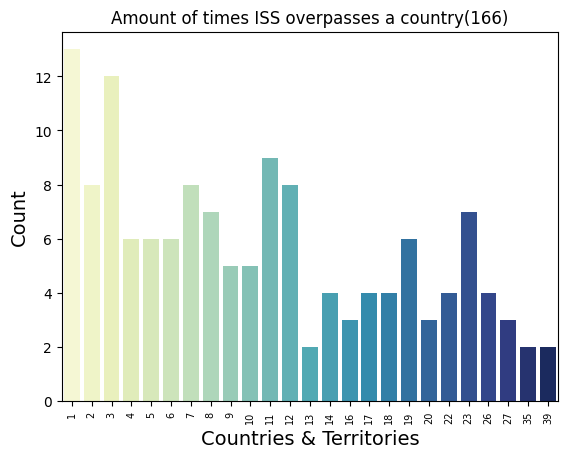

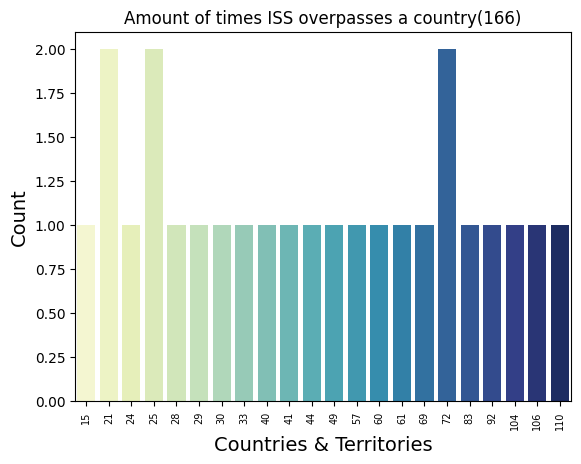

CPU times: user 1.22 s, sys: 9.54 ms, total: 1.23 s
Wall time: 1.93 s


In [234]:
# Note: Add a title argument for the function
%time plot_countriesbar(overpassed_df, title=group_title, x_value='Amount Overpassed', y_value='Count')

In [187]:
new_groupby_df['Count'] == 1

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [184]:
def function(data: pd.DataFrame, n=25, title="Different Bar Plots"):
    country_counts = dict()
    c = 200
    store = ''
    i = 1
    while i <= c:


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [222]:
new_grouping_df

,Count,Amount Overpassed
0,1,19
1,2,6
2,3,3
3,4,5
4,5,2
5,6,4
6,7,2
7,8,3
8,9,1
9,12,1


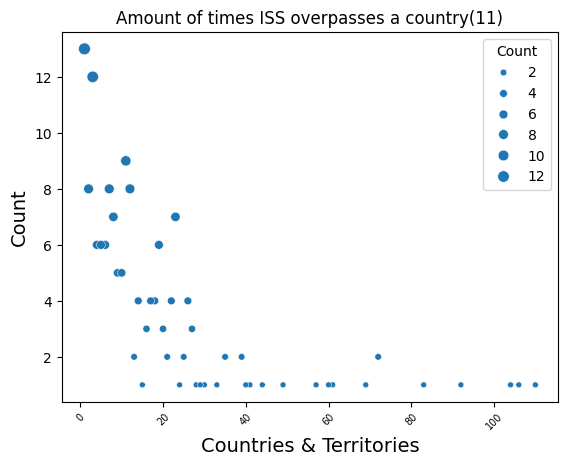

<Figure size 15000x15000 with 0 Axes>

In [225]:
ax = sns.scatterplot(data=overpassed_df, x='Amount Overpassed', y='Count', palette='YlGnBu', size='Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title(f"Amount of times ISS overpasses a country({len(new_grouping_df)})")
plt.figure(figsize=(150, 150))
plt.show()

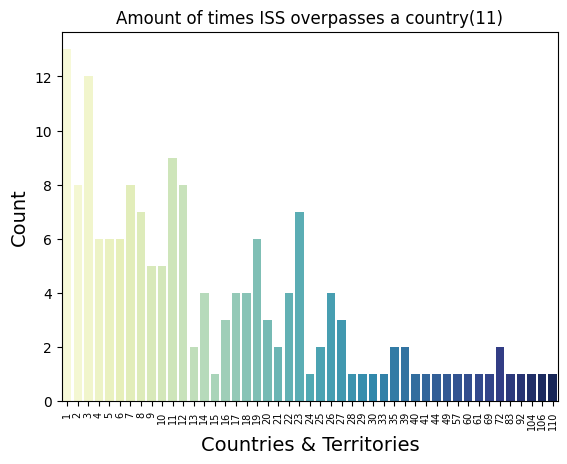

<Figure size 15000x15000 with 0 Axes>

In [237]:
ax = sns.barplot(data=overpassed_df, x='Amount Overpassed', y='Count', palette='YlGnBu')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title(f"Amount of times ISS overpasses a country({len(new_grouping_df)})")
plt.figure(figsize=(150, 150))
plt.show()

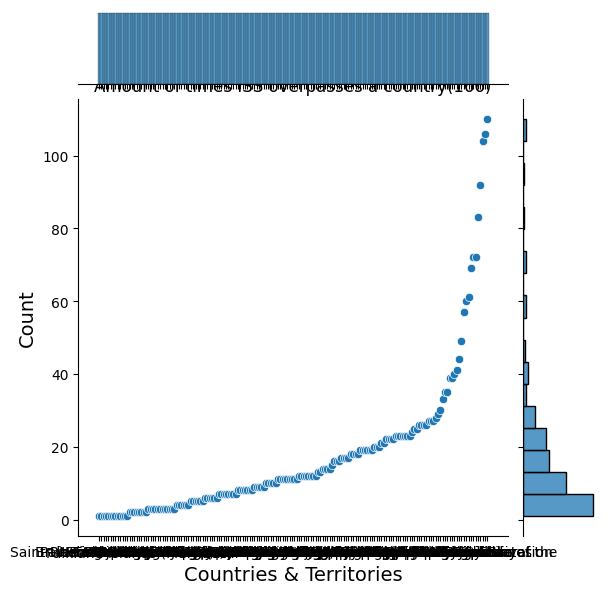

<Figure size 1500x1000 with 0 Axes>

In [164]:
ax = sns.jointplot(data=new_groupby_df, x='Countries', y='Count')#, palette={'Red','Green','Blue'}, size='Count')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title(f"Amount of times ISS overpasses a country({len(new_groupby_df)})")
plt.figure(figsize=(15, 10))
plt.show()

In [165]:
def plot_countries_points(data: pd.DataFrame, n=25, title="Different Scatter plots Plots"):
    """
    This function plots the countries and territories the ISS overpasses. It
    plots n number of countries at a time using seaborn and matplotlib
    Parameters
    ----------
    data : Pandas DataFrame
        A dataframe of countries and territories the ISS overpasses alongside
        how many times it overpasses them.
    n : int
        Number of countries to plot at a time.
    """
    start = 0
    stop = n
    amount = len(data)
    count = amount/n
    while(count>0):
      ax = sns.scatterplot(data=data[start:stop], x='Countries', y='Count', palette="YlGnBu")
      ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
      plt.xlabel("Countries & Territories", fontsize=14)
      plt.ylabel("Count", fontsize=14, )
      plt.title(title)
      plt.show()
      count -= 1
      start += n
      stop += n

In [239]:
def plot_countries_joint(data: pd.DataFrame, n=25, title="Different Join Plots"):
    """
    This function plots the countries and territories the ISS overpasses. It
    plots n number of countries at a time using seaborn and matplotlib
    Parameters
    ----------
    data : Pandas DataFrame
        A dataframe of countries and territories the ISS overpasses alongside
        how many times it overpasses them.
    n : int
        Number of countries to plot at a time.
    """
    start = 0
    stop = n
    amount = len(data)
    count = amount/n
    while(count>0):
      ax = sns.jointplot(data=data[start:stop], x='Amount Overpassed', y='Count', palette="YlGnBu")
      #ax.ax_joint.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
      plt.xlabel("Countries & Territories", fontsize=14)
      plt.ylabel("Count", fontsize=14)
      plt.title(title)
      plt.show()
      count -= 1
      start += n
      stop += n

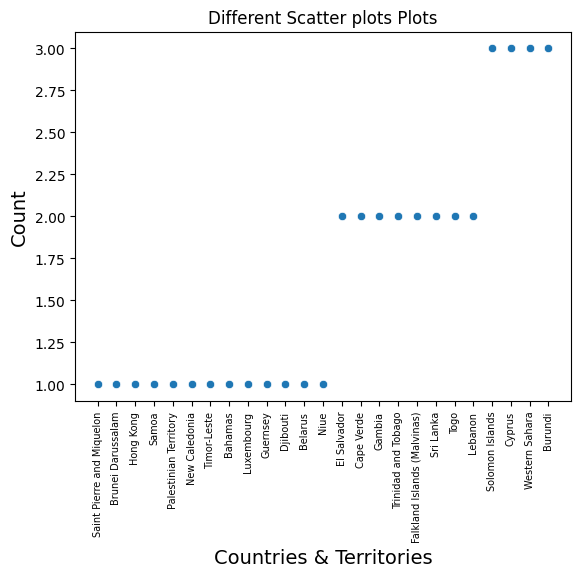

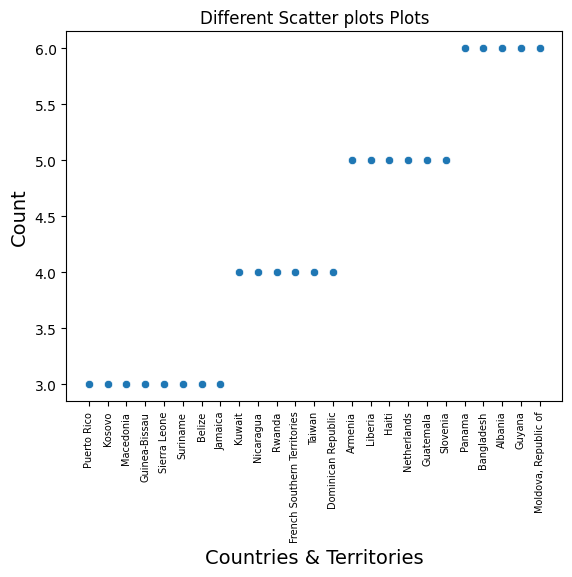

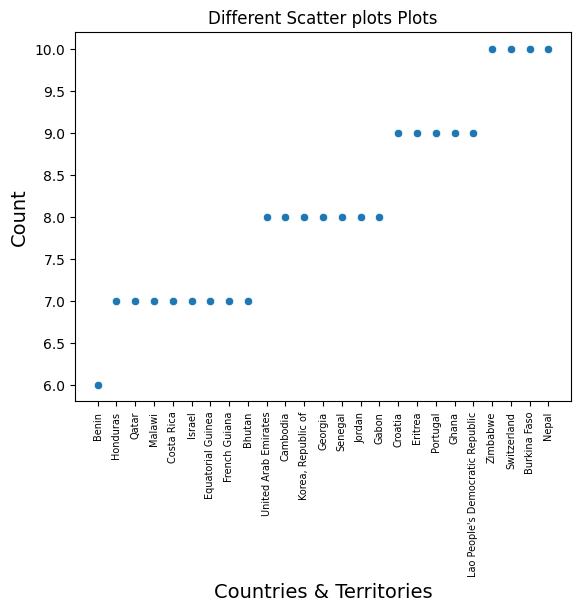

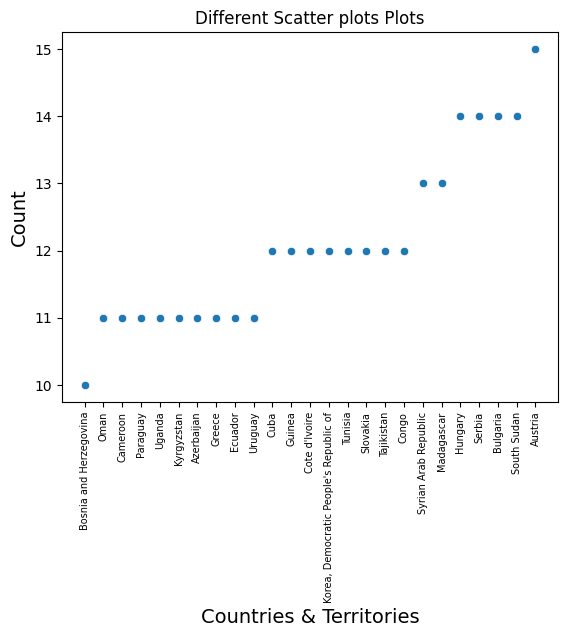

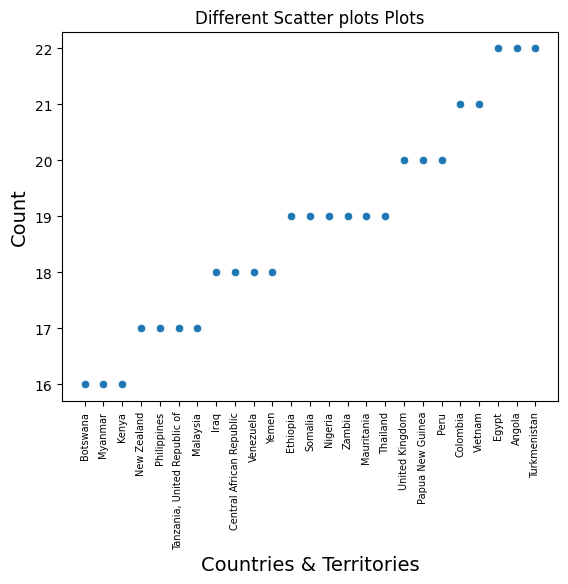

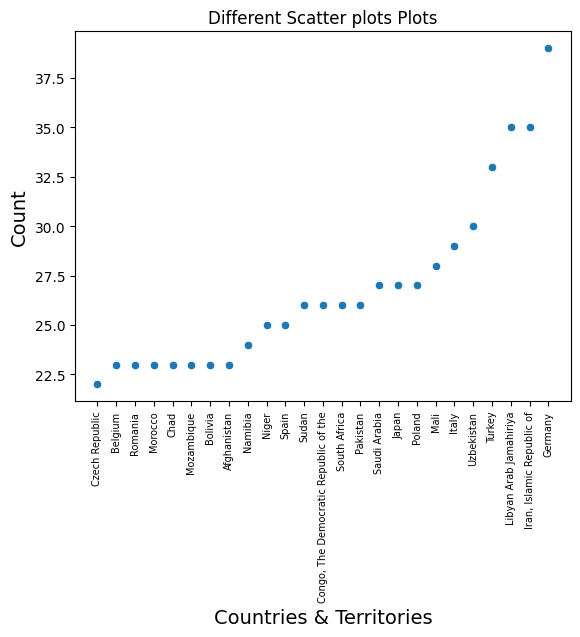

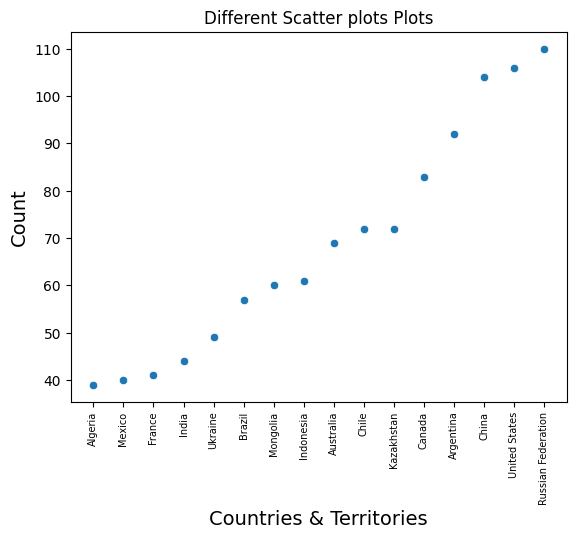

In [167]:
plot_countries_points(new_groupby_df)

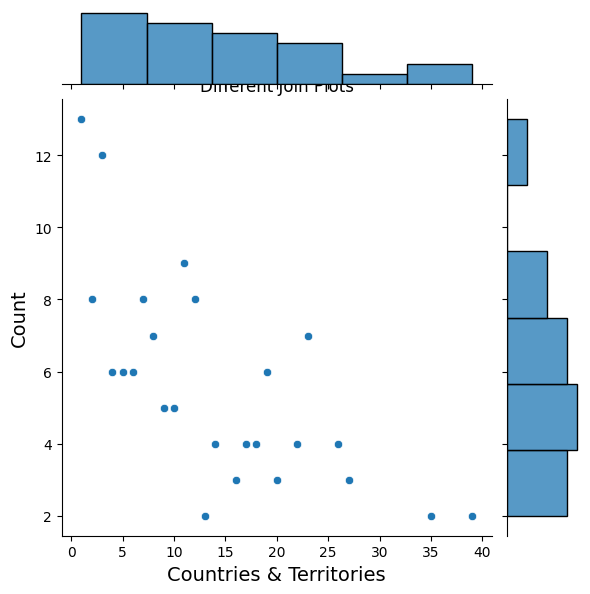

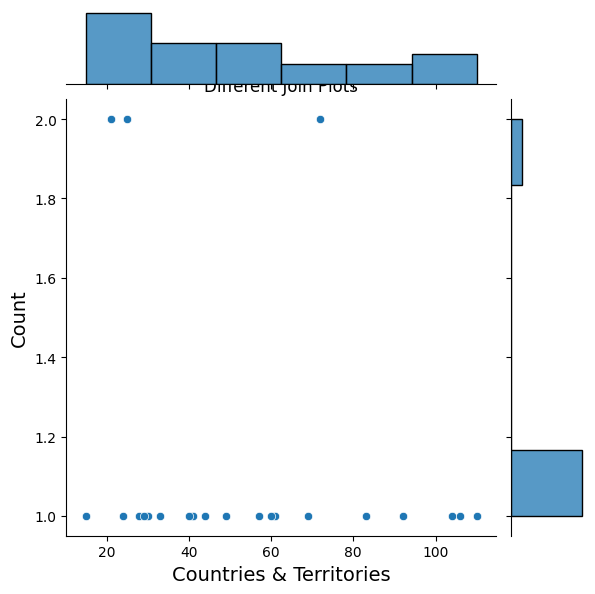

In [240]:
plot_countries_joint(overpassed_df)

within the radius of 20 miles of a specific point how many times will the ISS fly over.

In [ ]:
test_date = '2025-02-13 15:00:00'
test_date = dt.datetime.strptime(test_date, '%Y-%m-%d %H:%M:%S')

In [ ]:
test_date

In [ ]:
df['Date'].loc(test_date)

In [ ]:
type(test_date)

In [ ]:
df['Date'].info()